# An Example Jupyter Notebook for Unrolling Cylindrical Cell 'Jelly Rolls' and Detecting Electrode Buckling in X-ray CT Tomograms
This method unrolls a binary segmentation of a spiral (in this case the jelly roll of a cylindrical cell) from euclidean coordinatess into radial and angular coordinatess (a.k.a polar co-ordinates). This is similar to the method presented by Kok et al from which this takes inspiration,
see the paper [here](https://pubs.rsc.org/en/content/articlehtml/2019/se/c9se00500e#imgfig1). We then extract individual layers from the spiral and calculate the deviation of each layer from an ideal spiral. This allows for the determination of 'winding' quality. 

This notebook is organised like so:
1. Quick visualisation of the sample data
2. Exploration of how this unrolling method works 
3. Using utility functions to analyse the sample data 
4. Conclusion

In [1]:
import tifffile as tiff
import numpy as np
import numpy.ma as ma
import skimage
from skimage.measure import label as label
from scipy.ndimage import center_of_mass as c_of_m
from scipy.ndimage import distance_transform_edt as dist_trans
import matplotlib.pyplot as plt
import math
import os

os.chdir(os.path.dirname(os.getcwd()))
print(f"Correct Working Directory: {str(os.path.basename(os.getcwd()))=='battery_xct_notebooks'}")
import utils.unrolling_utils as nrol

Correct Working Directory: True


### 1. Visualise sample data

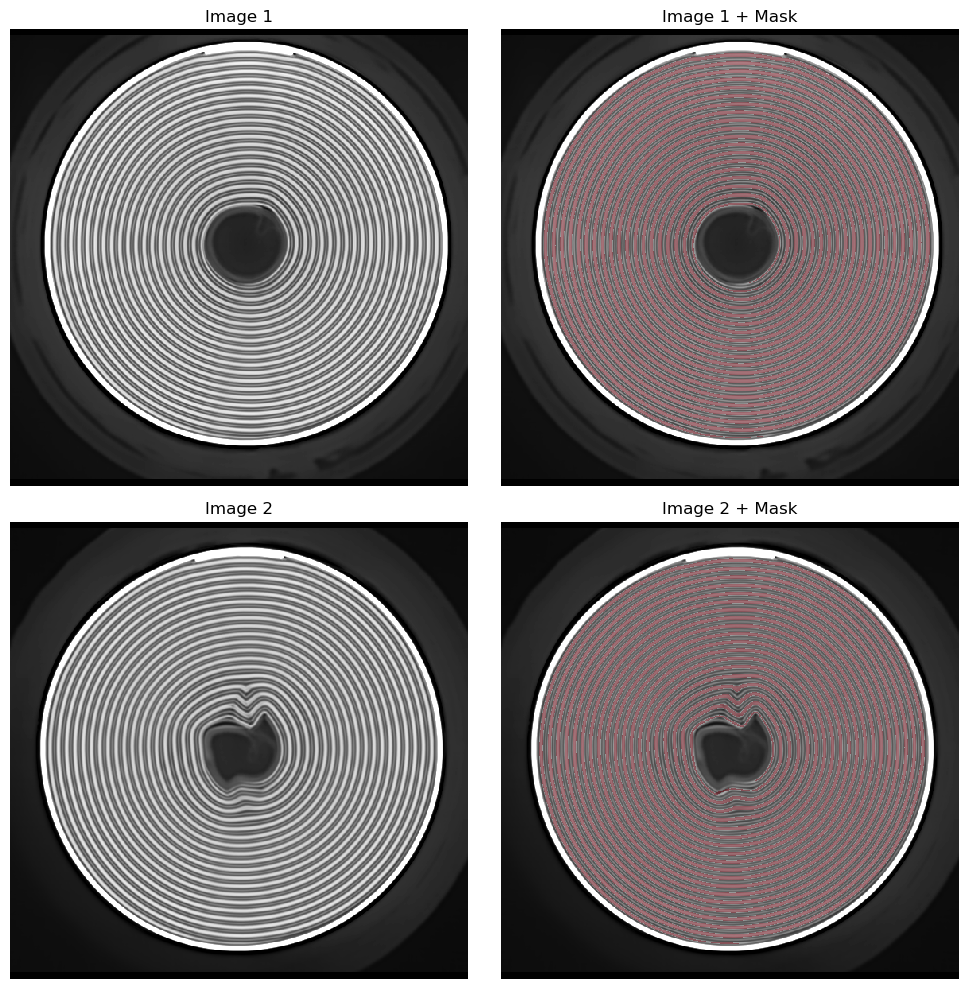

In [2]:
im1 = tiff.imread('data/im_1.tif')
mask1 =tiff.imread('data/mask_1.tif')
im2 = tiff.imread('data/im_2.tif')
mask2 =tiff.imread('data/mask_2.tif')

def show_overlay(img, msk, ax, title=""):
    # basic checks
    if img.shape != msk.shape:
        raise ValueError(f"Image/mask shapes differ: {img.shape} vs {msk.shape}")

    ax.imshow(img, cmap="gray", interpolation="nearest")
    alpha = (msk > 0).astype(float) * 0.5   # 0 where mask==0, 0.5 where mask>0
    ax.imshow(msk, cmap="Reds", alpha=alpha, interpolation="nearest")
    ax.set_title(title)
    ax.axis("off")

# ---- Visualize ----
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

# Img Msk Pair 1: image + overlay
axes[0].imshow(im1, cmap="gray", interpolation="nearest")
axes[0].set_title("Image 1")
axes[0].axis("off")
show_overlay(im1, mask1, axes[1], "Image 1 + Mask")

# Img Msk Pair 2: image + overlay
axes[2].imshow(im2, cmap="gray", interpolation="nearest")
axes[2].set_title("Image 2")
axes[2].axis("off")
show_overlay(im2, mask2, axes[3], "Image 2 + Mask")

plt.tight_layout()
plt.show()

Image 1 shows an undamaged cell, from the overlayed mask we can see that the mask accurately identifies the electrode pixels. Image 2 shows a damaged cell with buckled electrode layers at the center of the cell. Again the mask is accurate.

### 2. How does the unrolling work?
At its heart this is about assigning the segmented pixels polar coordinates via radial and arctan masks.

First define the centre of the spiral winding of the jelly roll.

In [3]:
com = c_of_m(mask1)
com = tuple(int(x) for x in com) #converting to int to remove subpixels
print('C_of_M is '+ str(com))

C_of_M is (270, 295)


Next we create a simple utility mask where the inside of the battery is =1 and outside is = 0. This can be nice for visualisation. This is not a important step however.

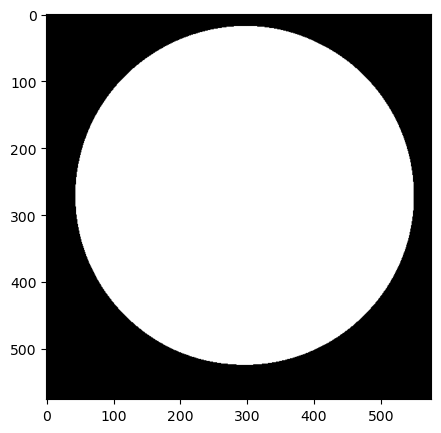

In [4]:
# first a basic utility mask where the inside of the battery is =1 and outside is = 0
casing_seg = np.where(im1 > 60000, 1, 0)
flooded_cell = skimage.segmentation.flood_fill(casing_seg, com, new_value = 1)
plt.figure(figsize=(5, 5))
plt.imshow(flooded_cell.astype(np.uint8), cmap='gray')
plt.show()

Next we create an image where every pixel is given a value based on its radial distance from the C_of_M using a euclidean distance transform. This is important for the unrolling as it is used to define the y-coordinate in the unrolled coordinate system.

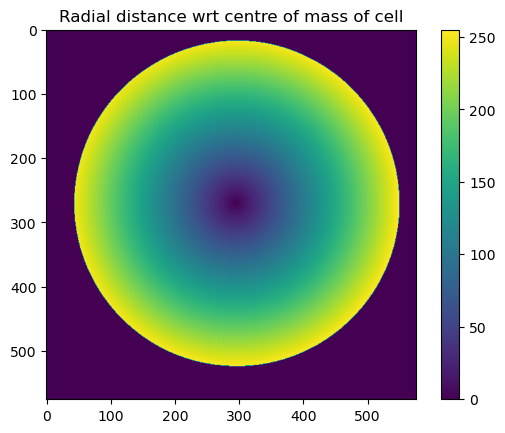

In [5]:
dist_transform = np.ones_like(im1)
dist_transform[com[0], com[1]] = 0
dist_transform = dist_trans(dist_transform.astype(np.uint16))
plt.imshow((dist_transform*flooded_cell).astype(np.uint16), cmap='viridis')
plt.colorbar()
plt.title('Radial distance wrt centre of mass of cell')
plt.show()

So in the image above each pixel inside the cell casing is labelled with its radial distance (in pixels) from the centre of the cell as defined by the C_of_M of the casing.

Next we have to label each pixel inside the cell with its angular position with respect to the C_of_M. In order to do this we need to calculate:

$$
    \theta = arctan(\frac{x - x_0}{y - y_0})
$$

Where $\theta$ is the new angular position, $x$ is x-coord of a pixel, $x_0$ is the x-coord of the CoM, $y$ is y-coord of a pixel, and $y_0$ is the y-coord of the CoM. In order to handle this calculation as arrays in a element-wise fashion we used the numpy.arctan2 function, documentation found [here](https://numpy.org/doc/stable/reference/generated/numpy.arctan2.html).

In [6]:
arr = np.zeros_like(im1)
arr = np.indices(arr.shape)
print(arr[0]) #arr[0] here returns the y-coord of each point in the image 
print(arr[1]) #similarly arr[1] will return x-coord

[[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [573 573 573 ... 573 573 573]
 [574 574 574 ... 574 574 574]
 [575 575 575 ... 575 575 575]]
[[  0   1   2 ... 573 574 575]
 [  0   1   2 ... 573 574 575]
 [  0   1   2 ... 573 574 575]
 ...
 [  0   1   2 ... 573 574 575]
 [  0   1   2 ... 573 574 575]
 [  0   1   2 ... 573 574 575]]


In [7]:
y_in = (arr[0] - com[0])
x_in = (arr[1] - com[1])
angular_arr = np.arctan2(x_in,y_in)

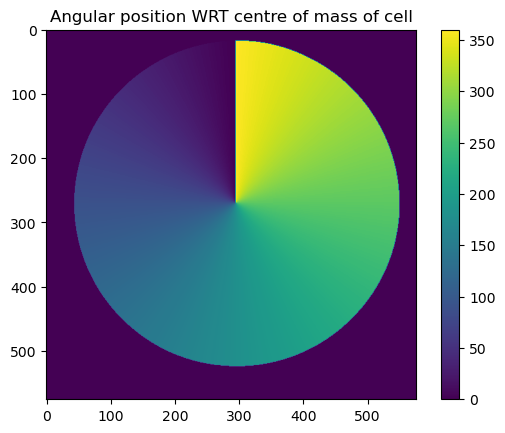

In [8]:
angular_arr = angular_arr * (180/math.pi) + 180 #convert into degrees with range between 0 - 360
plt.imshow((angular_arr*flooded_cell).astype(np.uint16), cmap='viridis')
plt.colorbar()
plt.title('Angular position WRT centre of mass of cell')
plt.show()

So in the image above each pixel inside the cell casing is labelled with its angular position (in degrees) with respect to the centre of the cell as defined by the C_of_M of the casing.

Now we mask out the radial/angular position images above with the segmentation of the phase of interest. This is shown below.

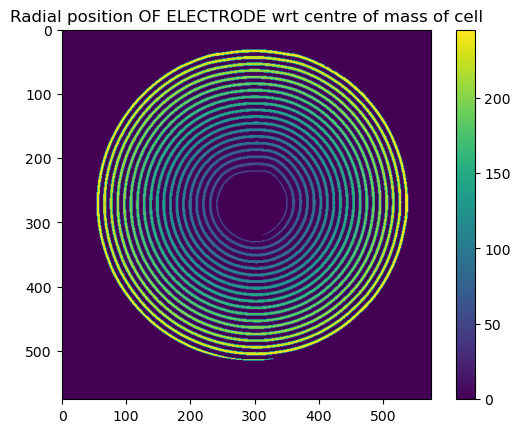

In [9]:
# radial
elec_radius_arr = dist_transform * np.where(mask1>0,1,0)
elec_radius_arr_masked = ma.masked_where(elec_radius_arr == 0, elec_radius_arr)
plt.imshow(elec_radius_arr.astype(np.uint16), cmap='viridis')
plt.colorbar()
plt.title('Radial position OF ELECTRODE wrt centre of mass of cell')
plt.show()

Thus, in the image above each electrode pixel from our segmentation is labelled with its radial position.

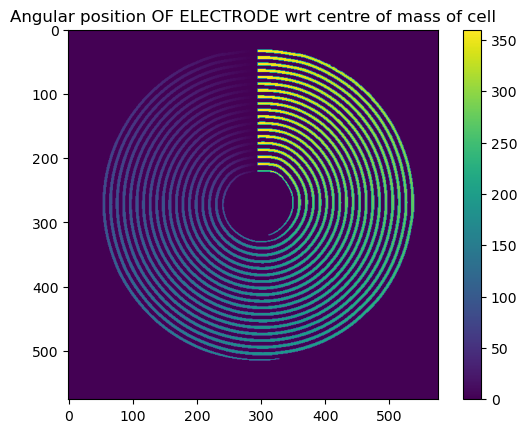

In [10]:
# anglular
elec_angle_arr = angular_arr * np.where(mask1>0,1,0)
elec_angle_arr_masked = ma.masked_where(elec_angle_arr == 0, elec_angle_arr)
plt.imshow(elec_angle_arr.astype(np.uint16), cmap='viridis')
plt.colorbar()
plt.title('Angular position OF ELECTRODE wrt centre of mass of cell')
plt.show()

Thus, in the image above each electrode pixel is labelled with it angular postition.

We now reduce these radial/angular position of electrode images (above) to one dimensional arrays. By combing the two 1D arrays we can descirbe the position of the electrode phase in a coordinate system of radial distance and  (a.k.a. polar co-ordinates). The data is now unrolled.

In [11]:
#to 1D
elec_radius_arr_masked = elec_radius_arr_masked[elec_radius_arr_masked.mask == False].ravel()
elec_angle_arr_masked = elec_angle_arr_masked[elec_angle_arr_masked.mask == False].ravel()

Now we can plot some simple results. We are going to plot the electrode on a 2d scatter in terms of angular position and distance from centre.

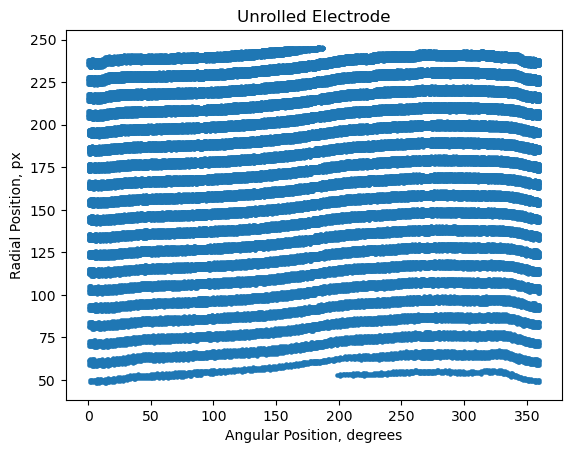

In [12]:
# now lets plot 
plt.scatter(elec_angle_arr_masked, elec_radius_arr_masked, s=5) # the s=5 is the size of the points and may need to be adjusted

# Set the axis labels
plt.xlabel('Angular Position, degrees', fontsize = 10)
plt.ylabel('Radial Position, px', fontsize = 10)

# Set the plot title
plt.title('Unrolled Electrode', fontsize = 12)

# Display the plot
plt.show()

But we can do better with our utility functions!

### 3. Analyse the sample data using the unrollr package
We have some functions to unroll and  analyse this kind of dataset. 

In [13]:
help(nrol.virtual_unroll)

Help on function virtual_unroll in module utils.unrolling_utils:

virtual_unroll(seg: numpy.ndarray, CoM: Union[Tuple[float, float], Sequence[float], numpy.ndarray, NoneType] = None, chunk_size: int = 75) -> pandas.core.frame.DataFrame
    Unroll a binary spiral segmentation into polar coordinates, split each winding
    into a separate labeled layer, and compute the local radial thickness.
    
    Parameters
    ----------
    seg : numpy.ndarray
        2D binary-like array (bool or 0/1) where nonzero/True pixels belong to the spiral.
        Shape: (H, W).
    CoM : tuple of float, sequence of float, or numpy.ndarray, optional
        Center of mass (y, x) used as the spiral origin. Accepts:
        - A length-2 tuple/list/array giving (y, x).
        - A 2D array mask (same shape as `seg`) from which center of mass will be computed
          via `c_of_m`.
        - If None (default), the center is computed from `seg` via `c_of_m(seg)`.
        The final center is cast to integer p

In [14]:
unrolled1 = nrol.virtual_unroll(mask1, com)
unrolled1.head()

,layer,angular_positions,radial_positions,chunk_thkn
0,1,[3.438181483183446],[244.8335888697162],[1.733581130437159]
1,2,"[45.66564309363311, 88.39172884612546, 131.470...","[53.55003955095812, 54.7121370748985, 54.62294...","[2.6757618789429998, 2.334390664354345, 2.7417..."
2,3,"[19.038268573788113, 47.84699747637565, 67.454...","[62.21137306557846, 63.51294156759505, 64.4400...","[4.342269418074686, 3.4518474045025798, 4.5836..."
3,4,"[8.107032503170242, 22.62436518713542, 36.8362...","[71.34124284478287, 72.95383937965883, 73.7741...","[5.2086552647734266, 4.660283667794076, 4.3664..."
4,5,"[6.9279019884307065, 19.528652185414828, 31.72...","[82.10445778429937, 83.2885400627029, 84.24324...","[4.521852080138203, 4.572220814596733, 4.55892..."


As you can see this outputs a pandas dataframe where each layer in the spiral is a row in the dataframe with associated radial and angular positions from the unrolling. The `chunk_thkn` refers to the thickness of the layer at each radial and angular position. 

An ideal cylindrical cell can be modelled as a archimedean spiral:

$r = a + b\theta$

This plots as a straight line in our polar co-ordinate system. Therefore by fitting straigh lines to the angular and radial positions we can easily calculate how much each layer then deviates from such an ideal shape.

In [15]:
help(nrol.add_linear_fit_errors)

Help on function add_linear_fit_errors in module utils.unrolling_utils:

add_linear_fit_errors(df: pandas.core.frame.DataFrame, angle_col: str = 'angular_positions', radius_col: str = 'radial_positions', errs_col: str = 'errors', rmse_col: str = 'rmse_lr', maxae_col: str = 'maxae_lr', slope_col: str = 'lr_slope', intercept_col: str = 'lr_intercept', use_radians: bool = False, copy: bool = True) -> pandas.core.frame.DataFrame
    Fit a linear model radius = a * angle + b for each layer and append error metrics.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Per-layer DataFrame (one row per layer) with list-like columns for angles and radii,
        e.g. the output of `virtual_unroll`.
    angle_col : str, optional
        Column name containing angular samples (list/array of floats, degrees by default).
    radius_col : str, optional
        Column name containing radial samples (list/array of floats).
    errs_col : str, optional
        Column name containing abs

In [16]:
unrolled1 = nrol.add_linear_fit_errors(unrolled1)
unrolled1.head()

,layer,angular_positions,radial_positions,chunk_thkn,errors,rmse_lr,maxae_lr,lr_slope,lr_intercept
0,1,[3.438181483183446],[244.8335888697162],[1.733581130437159],None,NaN,NaN,NaN,NaN
1,2,"[45.66564309363311, 88.39172884612546, 131.470...","[53.55003955095812, 54.7121370748985, 54.62294...","[2.6757618789429998, 2.334390664354345, 2.7417...","[1.131471769891327, 1.858778309740643, 1.33120...",2.064168,3.169485,0.010176,51.953863
2,3,"[19.038268573788113, 47.84699747637565, 67.454...","[62.21137306557846, 63.51294156759505, 64.4400...","[4.342269418074686, 3.4518474045025798, 4.5836...","[0.2791025530979212, 0.699720095670223, 1.4072...",1.883080,4.019555,0.011203,62.277189
3,4,"[8.107032503170242, 22.62436518713542, 36.8362...","[71.34124284478287, 72.95383937965883, 73.7741...","[5.2086552647734266, 4.660283667794076, 4.3664...","[1.788040955067899, 0.343820483508793, 0.31161...",1.813727,3.918770,0.011598,73.035256
4,5,"[6.9279019884307065, 19.528652185414828, 31.72...","[82.10445778429937, 83.2885400627029, 84.24324...","[4.521852080138203, 4.572220814596733, 4.55892...","[1.7150649985804023, 0.66728986742514, 0.15546...",1.771024,3.752610,0.010817,83.744581


We can plot this using inbuilt functions 

<Axes: title={'center': 'Unrolled Image 1'}, xlabel='Angular position (deg)', ylabel='Radial position (px)'>

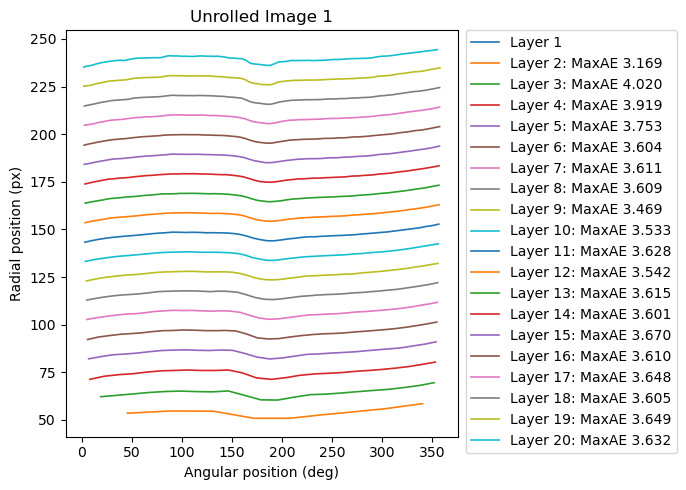

In [17]:
nrol.plot_unrolled_layers(unrolled1, title='Unrolled Image 1')

Above we have plotted the layers and also calculated their deviation (MaxAE) from an ideal Archimedean spiral, in this case this is given in pixel units.

Now lets do the same for `im2` which had some buckled electrode layers.

<Axes: title={'center': 'Unrolled Image 2'}, xlabel='Angular position (deg)', ylabel='Radial position (px)'>

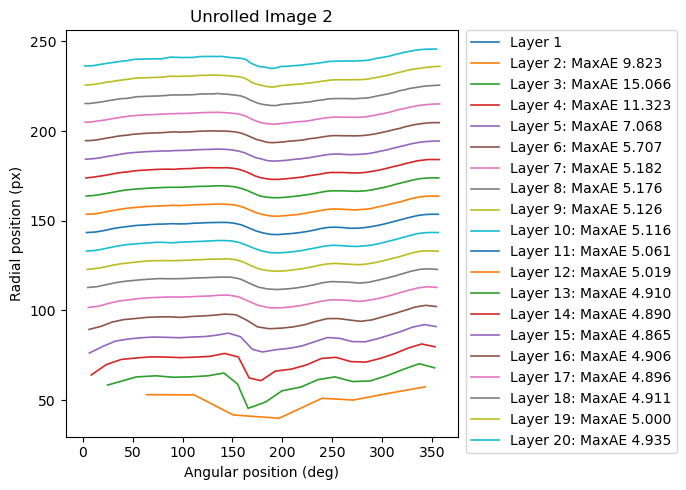

In [18]:
unrolled2 = nrol.virtual_unroll(mask2)
unrolled2 = nrol.add_linear_fit_errors(unrolled2)
nrol.plot_unrolled_layers(unrolled2, title='Unrolled Image 2')

Alternatively, we can plot the layers with color mapping to the deviation from the spiral

<Axes: title={'center': 'Unrolled Image 2'}, xlabel='Angular position (deg)', ylabel='Radial position (px)'>

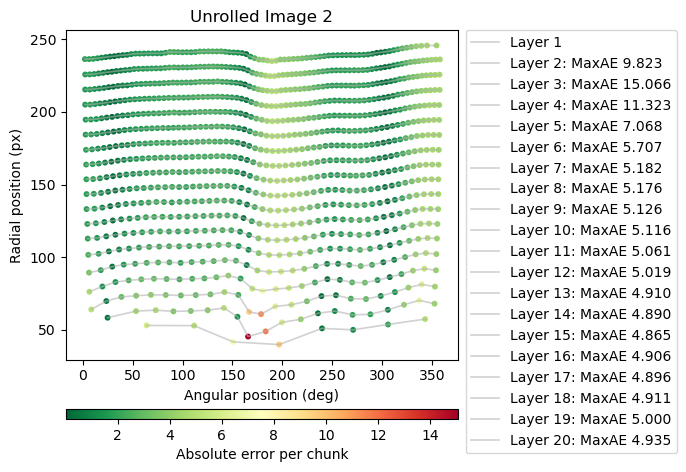

In [19]:
nrol.plot_unrolled_layers(unrolled2, title='Unrolled Image 2', color_by_error=True)

We can see far greater non-linearity in the unrolled data. This is quantified by the large MaxAE values. We see that the layers near the center of the cell that have buckled deviate considerably from the ideal archimedean spiral (layer 2 deviates by 15 px). 

### 4. Conclusion
This method may prove beneficial to battery quality control and manufacturing where it could be used to inform the assessment of winding quality automatically from XCT tomograms.
If you have any questions or comments on this notebook please contact the authors.